In [ ]:
!pip install -q pytorch-tabular

In [ ]:
# Menambahkan path direktori Kode_Skripsi untuk mengimpor file functions.py
import sys
sys.path.append('/content/drive/MyDrive/Kode_Skripsi')

In [ ]:
!cp /content/drive/MyDrive/Kode_Skripsi/functions.py /content/

Preprocessing

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, precision_score, roc_auc_score,log_loss, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.utils.class_weight import compute_class_weight

import torch
import os
import functions

In [ ]:
# Mengabaikan warning penggunaan processor dan konfigurasi penggunaan weight terbaik dari epoch sebelumnya
functions.ignore_warnings()

In [ ]:
# Mengambil dataset RT IoT 2022
rt_iot2022_6classes = '/content/drive/MyDrive/Dataset_Skripsi/6_Classes/RT_IOT2022_6Classes.csv'

df = pd.read_csv(rt_iot2022_6classes)

# Memisahkan kolom fitur dan target
X = df.drop(columns=['Attack_type'])
y = df['Attack_type']

In [ ]:
# Menyimpan label asli sebelum encoding agar tidak ikut termodifikasi
y_label = y.copy()

# Melakukan encoding label utama (y) sekali untuk StratifiedKFold
y_encoded = LabelEncoder().fit_transform(y.squeeze())

In [ ]:
# Menampilkan hasil encoding
functions.show_label_encoding(y, y_encoded)

===== Mapping Label Encoding (Attack_type) =====
     Label_Original  Label_Encoded
     ARP_poisioning              0
     DDOS_Slowloris              1
  NMAP_OS_DETECTION              2
      NMAP_TCP_scan              3
      NMAP_UDP_SCAN              4
NMAP_XMAS_TREE_SCAN              5


##TabNet

In [ ]:
# Melakukan Stratified K-Fold dengan 5 fold dan hasilnya diacak
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Memastikan folder Model_Skripsi tersedia
os.makedirs("/content/drive/MyDrive/Model_Skripsi/", exist_ok=True)

In [ ]:
# Melakukan inisialisasi untuk menyimpan kurva metrik per epoch dalam setiap fold
fold_logloss_curve = []
fold_accuracy_curve = []

# Melakukan inisialisasi untuk nantinya menyimpan metrik setiap fold
fold_results = {
    'fold': [],
    'accuracy': [],
    'f1_score': [],
    'precision': [],
    'roc_auc': [],
    'log_loss': []
}

# Melakukan inisialisasi model terbaik
best_model_path = ""

best_logloss = float('inf')
best_y_true = None
best_preds = None

# Melakukan inisialisasi untuk nilai epoch dan patience yang sedang digunakan
n_epochs=50
n_patience=15

# Melakukan Cross-validation
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_encoded)):
    print(f"\nFold {fold+1}")

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Melakukan encoding dan scaling
    X_train_np, X_test_np, y_train_np, y_test_np = functions.encoding_rt_iot22_balanced(X_train, X_test, y_train, y_test)


    # Menggunakan compute class weights untuk bobot balancing dataset
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_np),
        y=y_train_np
    )
    sample_weights = class_weights[y_train_np]

    # Melakukan training TabNet
    tabnet_model = TabNetClassifier(
        optimizer_fn=torch.optim.Adam,
        optimizer_params={"lr": 1e-3},
        device_name='cuda' if torch.cuda.is_available() else 'cpu',
        seed=42
    )

    tabnet_model.fit(
        X_train=X_train_np, y_train=y_train_np,
        eval_set=[(X_test_np, y_test_np)],
        eval_name=["val"],
        eval_metric=["accuracy", "logloss"],
        patience=n_patience,
        max_epochs=n_epochs,
        batch_size=1024,
        weights=sample_weights  # Menggunakan class weight per sample
    )



    # Melakukan evaluasi pada metrik accuracy, F1-score, dan precision
    preds = tabnet_model.predict(X_test_np)
    pred_proba = tabnet_model.predict_proba(X_test_np)

    acc = accuracy_score(y_test_np, preds)
    f1 = f1_score(y_test_np, preds, average='macro')
    precision = precision_score(y_test_np, preds, average='macro')
    logloss = min(tabnet_model.history['val_logloss']) # Menggunakan logloss terbaik dari proses fit


    # Menghitung multiclass AUC-ROC
    try:
        auc = roc_auc_score(y_test_np, pred_proba, multi_class='ovr', average='macro')
    except:
        auc = None

    try:
        fold_logloss_curve.append(tabnet_model.history['val_logloss'])
        fold_accuracy_curve.append(tabnet_model.history['val_accuracy'])
    except KeyError as e:
        print(f"KeyError: {e} tidak ditemukan dalam tabnet.history.")
        print("Available keys:", tabnet_model.history.keys())

    # Menyimpan model terbaik berdasarkan logloss
    if logloss < best_logloss:
        best_logloss = logloss
        best_model = tabnet_model
        best_fold = fold + 1
        best_preds = preds
        best_y_true = y_test_np

    print(f"Fold {fold+1} Metrics:")
    print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, LogLoss: {logloss:.4f}, AUC: {auc:.4f}")

    # Menyimpan semua nilai metrik ke dictionary hasil
    fold_results['fold'].append(fold + 1)
    fold_results['accuracy'].append(acc)
    fold_results['f1_score'].append(f1)
    fold_results['precision'].append(precision)
    fold_results['roc_auc'].append(auc)
    fold_results['log_loss'].append(logloss)



Fold 1
epoch 0  | loss: 2.51377 | val_accuracy: 0.14255 | val_logloss: 2.04992 |  0:00:01s
epoch 1  | loss: 2.40686 | val_accuracy: 0.07451 | val_logloss: 2.1077  |  0:00:02s
epoch 2  | loss: 2.34685 | val_accuracy: 0.07739 | val_logloss: 2.09884 |  0:00:02s
epoch 3  | loss: 2.27112 | val_accuracy: 0.07235 | val_logloss: 2.072   |  0:00:03s
epoch 4  | loss: 2.18795 | val_accuracy: 0.06983 | val_logloss: 2.07421 |  0:00:03s
epoch 5  | loss: 2.16088 | val_accuracy: 0.07235 | val_logloss: 1.99262 |  0:00:04s
epoch 6  | loss: 2.13193 | val_accuracy: 0.09287 | val_logloss: 1.96744 |  0:00:04s
epoch 7  | loss: 2.08506 | val_accuracy: 0.10115 | val_logloss: 1.95644 |  0:00:05s
epoch 8  | loss: 2.03416 | val_accuracy: 0.09539 | val_logloss: 1.9365  |  0:00:05s
epoch 9  | loss: 1.97842 | val_accuracy: 0.14759 | val_logloss: 1.91961 |  0:00:06s
epoch 10 | loss: 1.92363 | val_accuracy: 0.17675 | val_logloss: 1.90481 |  0:00:06s
epoch 11 | loss: 1.93056 | val_accuracy: 0.24622 | val_logloss: 1.89

In [ ]:
# Menyimpan model terbaik pada database
if best_model is not None:
    if n_epochs == 100 and n_patience == 15:
        best_model_path = f"/content/drive/MyDrive/Model_Skripsi/TabNet/epoch_100/RT-IoT-2022_tabnet__best_model_fold{best_fold}_logloss{best_logloss:.6f}"
    elif n_epochs == 50 and n_patience == 15:
        best_model_path = f"/content/drive/MyDrive/Model_Skripsi/TabNet/epoch_50/RT-IoT-2022_tabnet_best_model_fold{best_fold}_logloss{best_logloss:.6f}"


    best_model.save_model(best_model_path)
    print(f"Model terbaik disimpan dari Fold {best_fold} dengan logloss: {best_logloss:.6f}")


Successfully saved model at /content/drive/MyDrive/Model_Skripsi/TabNet/epoch_50/RT-IoT-2022_tabnet_best_model_fold2_logloss0.466018.zip
Model terbaik disimpan dari Fold 2 dengan logloss: 0.466018


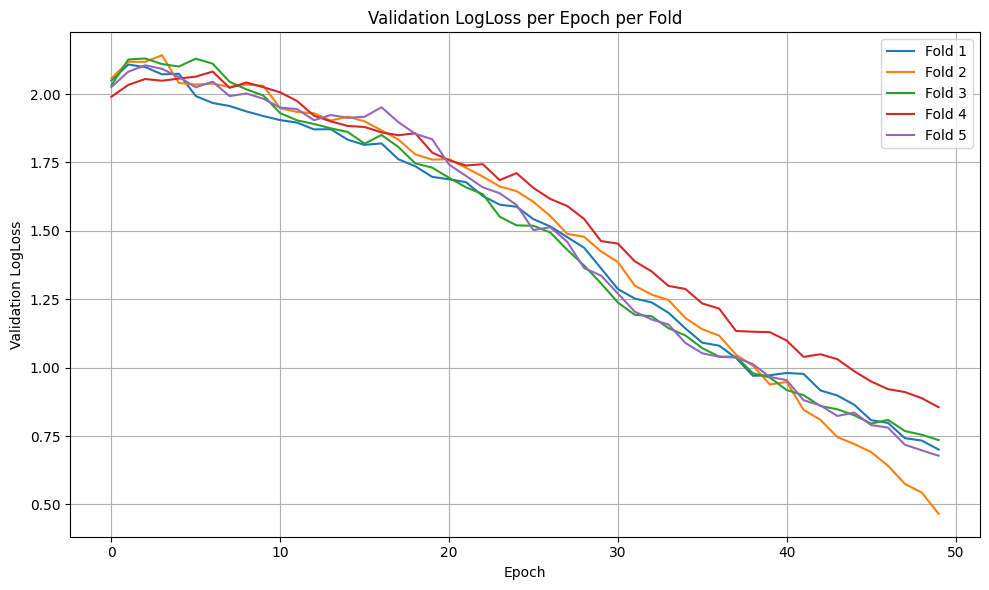

In [ ]:
# Menampilkan visualisasi kurva logloss per epoch pada setiap fold
functions.plot_curve(fold_logloss_curve, metric_name="Validation LogLoss")

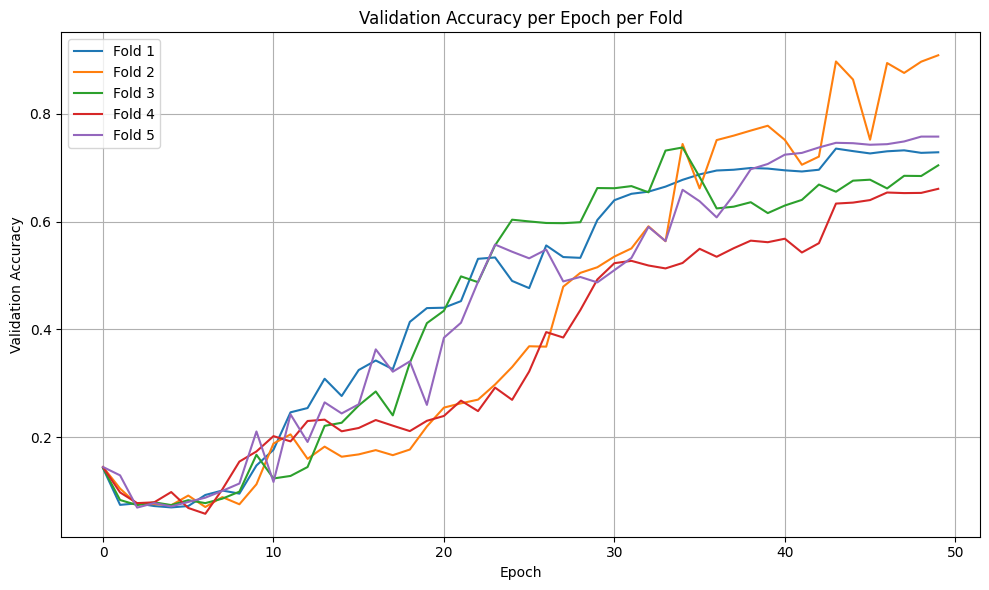

In [ ]:
# Menampilkan visualisasi kurva accuracy per epoch pada setiap fold
functions.plot_curve(fold_accuracy_curve, metric_name="Validation Accuracy")

In [ ]:
# Menampilkan rata-rata semua metrik dari semua fold
print("\nRata-Rata Hasil Cross Validation:")
for metric in ['accuracy', 'f1_score', 'precision', 'roc_auc', 'log_loss']:
    avg_value = np.mean([val for val in fold_results[metric] if val is not None])
    print(f"{metric}: {avg_value:.4f}")


Rata-Rata Hasil Cross Validation:
accuracy: 0.7520
f1_score: 0.7570
precision: 0.7616
roc_auc: 0.9642
log_loss: 0.6872


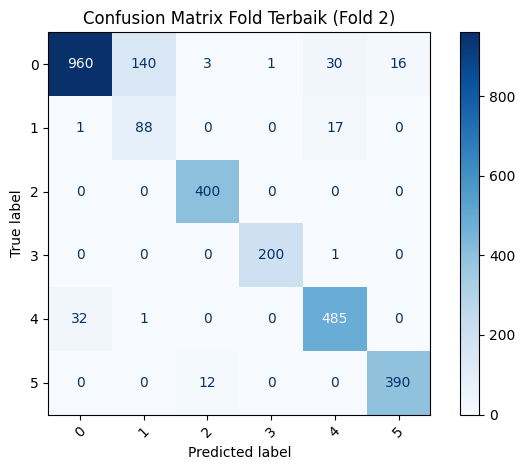

In [ ]:
# Menampilkan visualisasi keakuratan prediksi model
functions.plot_best_confusion_matrix(best_y_true, best_preds, best_fold)